## **Part(1): prediction using mobilenet_v2 feature extractor**

In [75]:
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [76]:
# step(1) : load data and split it into training and validation set
(train_examples, validation_examples), info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

# number of training data 
num_examples = info.splits['train'].num_examples
# number of output classes
num_classes = info.features['label'].num_classes

In [77]:
# investigate the shape of some images to know if we need preprocessing 
for i, example_image in enumerate(train_examples.take(5)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (333, 500, 3)
Image 2 shape: (212, 320, 3)
Image 3 shape: (240, 320, 3)
Image 4 shape: (240, 320, 3)
Image 5 shape: (317, 500, 3)


In [78]:
# input image size
IMAGE_RES = 224 
# step(2): preproces(scale,normalize) input images 
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

# step(3): Apply preprocessing on each batch of the training and validation data 
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [79]:
# step(4): Get feature vector of the (mobilenet) network v4 as a  keras layer with the appropriate input  
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [80]:
# passing a batch to the network to know the size of the feature vector 
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [81]:
# Keep the weights of the pretrained model from the start to the feature extractor   
feature_extractor.trainable = False

In [82]:
# step(5): Add new dense layer to match our output classes 

model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 645       
Total params: 3,078,725
Trainable params: 820,741
Non-trainable params: 2,257,984
_________________________________________________________________


In [83]:
# step(6): compile and train the model 
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 10s 78ms/step - loss: 0.5594 - accuracy: 0.7906 - val_loss: 0.3011 - val_accuracy: 0.8974
Epoch 2/10
81/81 [==============================] - 4s 51ms/step - loss: 0.2613 - accuracy: 0.9042 - val_loss: 0.2949 - val_accuracy: 0.8928
Epoch 3/10
81/81 [==============================] - 4s 51ms/step - loss: 0.1516 - accuracy: 0.9506 - val_loss: 0.3563 - val_accuracy: 0.8901
Epoch 4/10
81/81 [==============================] - 4s 51ms/step - loss: 0.1049 - accuracy: 0.9619 - val_loss: 0.3250 - val_accuracy: 0.8955
Epoch 5/10
81/81 [==============================] - 4s 51ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 0.3661 - val_accuracy: 0.9173
Epoch 6/10
81/81 [==============================] - 4s 51ms/step - loss: 0.0417 - accuracy: 0.9852 - val_loss: 0.4640 - val_accuracy: 0.8892
Epoch 7/10
81/81 [==============================] - 4s 51ms/step - loss: 0.0577 - accuracy: 0.9805 - val_loss: 0.4301 - val_accuracy: 0.8901
Epoch 8/10
8

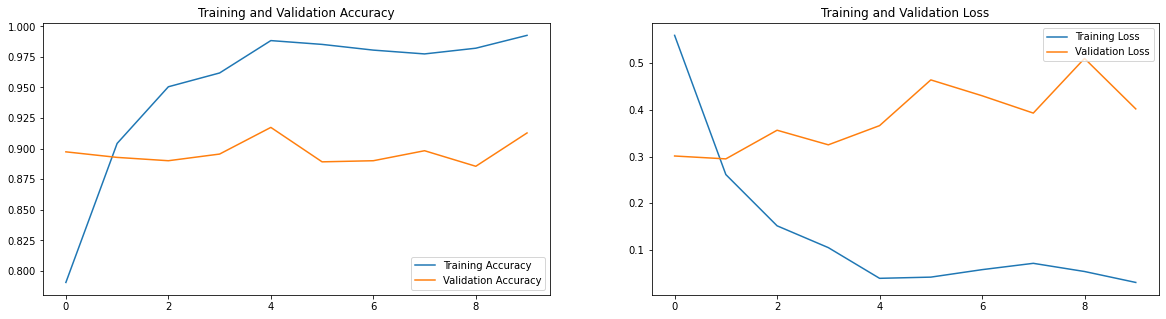

In [84]:
# step(7): visulaize the loss and the accuracy of training and validation data 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [85]:
import numpy as np 
# step (8) : Make prediction on a batch
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [86]:
# prediction of one batch
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['daisy', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'tulips',
       'sunflowers', 'daisy', 'tulips', 'dandelion', 'sunflowers',
       'dandelion', 'roses', 'tulips', 'tulips', 'tulips', 'tulips',
       'dandelion', 'dandelion', 'daisy', 'dandelion', 'daisy',
       'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers',
       'daisy', 'daisy', 'sunflowers', 'daisy', 'roses'], dtype='<U10')

In [87]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 2 2 3 0 2 3 1 2 0 3 0 4 2 2 2 2 0 0 1 0 1 3 3 3 2 3 1 1 3 1 4]
Predicted labels:  [1 2 2 3 0 2 3 1 2 0 3 0 4 2 2 2 2 0 0 1 0 1 3 3 3 2 3 1 1 3 1 4]


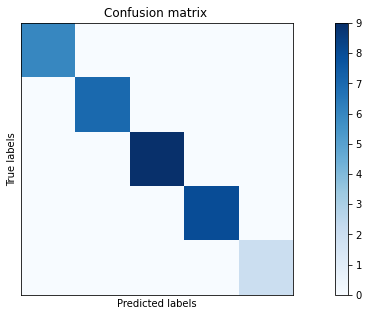

In [88]:
# confusion matrix 
import sklearn
matrix = tf.math.confusion_matrix(label_batch,predicted_ids)
plt.figure(figsize=(15,5))
plt.imshow(matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

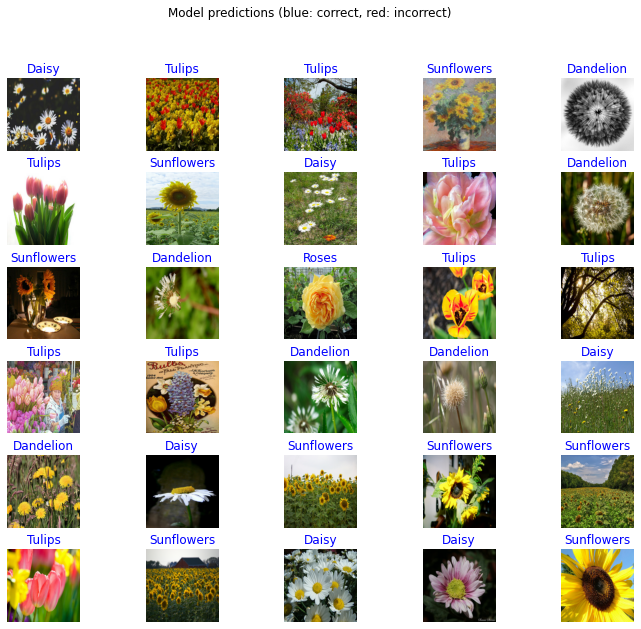

In [89]:
# visualize prediction of a batch
plt.figure(figsize=(12,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## **Part(2): prediction using inception_v3 feature extractor**

In [90]:
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [91]:
# step(1) : load data and split it into training and validation set
(train_examples, validation_examples), info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

# number of training data 
num_examples = info.splits['train'].num_examples
# number of output classes
num_classes = info.features['label'].num_classes

In [92]:
# investigate the shape of some images to know if we need preprocessing 
for i, example_image in enumerate(train_examples.take(5)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (333, 500, 3)
Image 2 shape: (212, 320, 3)
Image 3 shape: (240, 320, 3)
Image 4 shape: (240, 320, 3)
Image 5 shape: (317, 500, 3)


In [93]:
# input image size 
IMAGE_RES2 = 299 
# step(2): preproces(scale,normalize) input images 
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES2, IMAGE_RES2))/255.0
  return image, label

BATCH_SIZE = 32

# step(3): Apply preprocessing on each batch of the training and validation data 
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [94]:
# step(4): Get feature vector of the (mobilenet) network v4 as a  keras layer with the appropriate input  
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor2 = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES2, IMAGE_RES2,3))

In [95]:
# passing a batch to the network to know the size of the feature vector 
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

feature_batch = feature_extractor2(image_batch)
print(feature_batch.shape)

(32, 2048)


In [96]:
# Keep the weights of the pretrained model from the start to the feature extractor   
feature_extractor2.trainable = False

In [97]:
# step(5): Add new dense layer to match our output classes 

model2 = tf.keras.Sequential([
  feature_extractor2,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_17 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 645       
Total params: 23,016,741
Trainable params: 1,213,957
Non-trainable params: 21,802,784
_________________________________________________________________


In [98]:
# step(6): compile and train the model 
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10
history2 = model2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 20s 186ms/step - loss: 0.5773 - accuracy: 0.7890 - val_loss: 0.4949 - val_accuracy: 0.8174
Epoch 2/10
81/81 [==============================] - 15s 181ms/step - loss: 0.3247 - accuracy: 0.8879 - val_loss: 0.2963 - val_accuracy: 0.8892
Epoch 3/10
81/81 [==============================] - 15s 182ms/step - loss: 0.2233 - accuracy: 0.9241 - val_loss: 0.2811 - val_accuracy: 0.9001
Epoch 4/10
81/81 [==============================] - 14s 177ms/step - loss: 0.1489 - accuracy: 0.9471 - val_loss: 0.3355 - val_accuracy: 0.8847
Epoch 5/10
81/81 [==============================] - 14s 174ms/step - loss: 0.1268 - accuracy: 0.9545 - val_loss: 0.2994 - val_accuracy: 0.9037
Epoch 6/10
81/81 [==============================] - 14s 178ms/step - loss: 0.1132 - accuracy: 0.9611 - val_loss: 0.3984 - val_accuracy: 0.8783
Epoch 7/10
81/81 [==============================] - 15s 180ms/step - loss: 0.0798 - accuracy: 0.9677 - val_loss: 0.3863 - val_accuracy: 0.8883

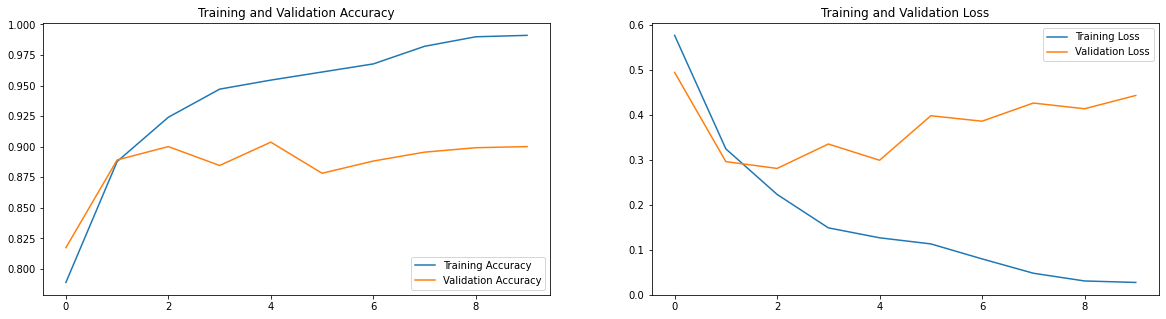

In [99]:
# step(7): visulaize the loss and the accuracy of training and validation data 
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [100]:
import numpy as np 
# step (8) : Make prediction on a batch
class_names2 = np.array(info.features['label'].names)
class_names2

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [101]:
# prediction of one batch
predicted_batch2 = model2.predict(image_batch)
predicted_batch2 = tf.squeeze(predicted_batch2).numpy()
predicted_ids2 = np.argmax(predicted_batch2, axis=-1)
predicted_class_names2 = class_names2[predicted_ids2]
predicted_class_names2

array(['daisy', 'daisy', 'dandelion', 'roses', 'sunflowers', 'sunflowers',
       'roses', 'roses', 'roses', 'dandelion', 'sunflowers', 'dandelion',
       'dandelion', 'roses', 'sunflowers', 'tulips', 'dandelion',
       'dandelion', 'dandelion', 'tulips', 'tulips', 'tulips', 'tulips',
       'tulips', 'sunflowers', 'daisy', 'daisy', 'daisy', 'daisy',
       'daisy', 'daisy', 'dandelion'], dtype='<U10')

In [102]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids2)

Labels:  [1 1 0 4 3 3 4 4 4 0 3 0 0 4 3 2 0 0 0 2 2 2 2 2 3 1 1 1 1 1 1 0]
Predicted labels:  [1 1 0 4 3 3 4 4 4 0 3 0 0 4 3 2 0 0 0 2 2 2 2 2 3 1 1 1 1 1 1 0]


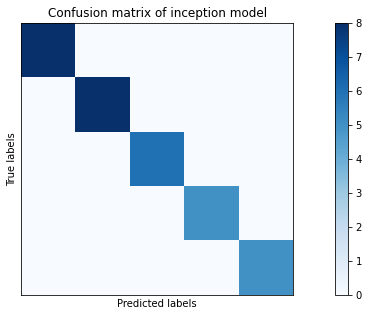

In [103]:
# confusion matrix 
import sklearn
matrix = tf.math.confusion_matrix(label_batch,predicted_ids2)
plt.figure(figsize=(15,5))
plt.imshow(matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix of inception model')
plt.colorbar()
plt.show()

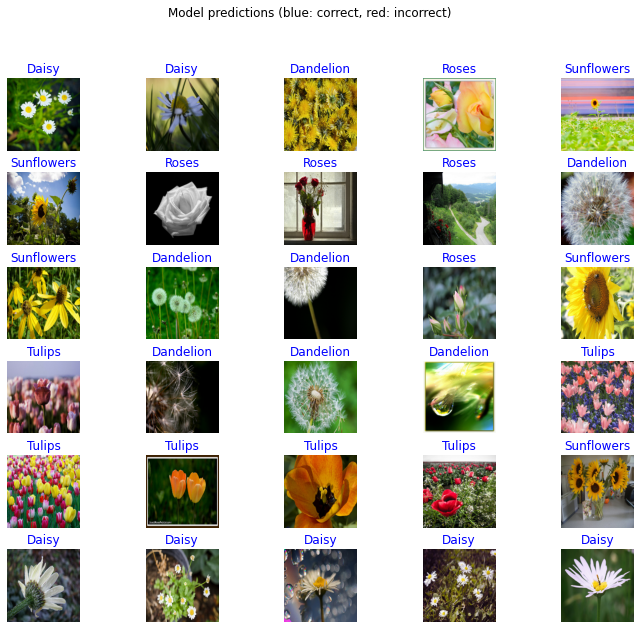

In [104]:
# visualize prediction of a batch
plt.figure(figsize=(12,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids2[n] == label_batch[n] else "red"
  plt.title(predicted_class_names2[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

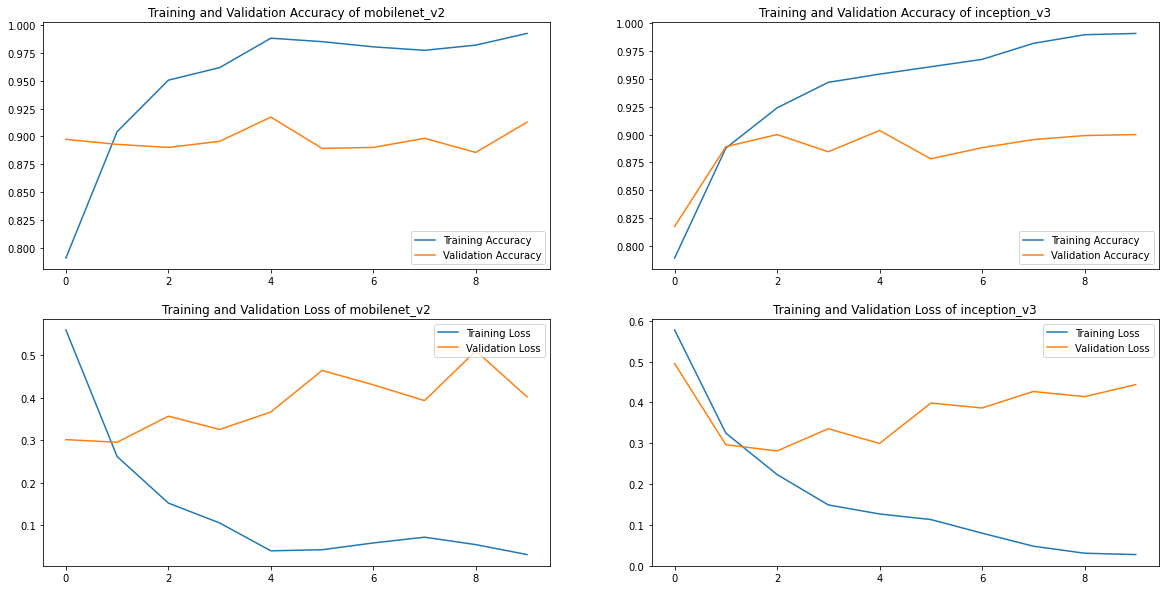

In [106]:
# Compare between the loss and the accuracy of the two models 
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(EPOCHS)
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of mobilenet_v2')


plt.subplot(2, 2, 2)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of inception_v3')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of mobilenet_v2')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of inception_v3')

plt.show()